In [ ]:
from functools import partial
import itertools
import json
import logging
from pathlib import Path
import re
import subprocess
import sys
import textwrap
import typing as t

import tiktoken

import numpy as np
import pandas as pd

from ragas.metrics import (
    Faithfulness,
    LLMContextRecall,
    ResponseRelevancy,
    SemanticSimilarity,
)
from ragas.metrics._context_precision import LLMContextPrecisionWithReference
from ragas.testset.synthesizers.prompts import (
    AbstractQueryFromTheme,
    CommonConceptsFromKeyphrases,
    CommonThemeFromSummariesPrompt,
    ComparativeAbstractQuery,
    CriticUserInput,
    GenerateReference,
    ModifyUserInput,
    SpecificQuery,
)
from ragas.testset.transforms.extractors.llm_based import (
    HeadlinesExtractorPrompt,
    KeyphrasesExtractorPrompt,
    NERPrompt,
    SummaryExtractorPrompt,
    TitleExtractorPrompt,
)

import matplotlib.pyplot as plt

In [ ]:
repo = subprocess.check_output(  # NOQA: S603
    ["git", "rev-parse", "--show-toplevel"],  # NOQA: S607
    cwd=Path(__file__).parent,
    encoding="utf-8",
).strip()
repo = Path(repo).resolve()

datadir = Path(__file__).parent / "data"

In [ ]:
sys.path.insert(0, str(Path(__file__).parent))
from src.ragas.helpers import run_ragas_evals, validate_metrics  # NOQA: E402
from src.utils import filter_dict_by_keys, pwrap  # NOQA: E402

In [ ]:
LOG_FMT = "%(asctime)s - %(levelname)-8s - %(name)s - %(funcName)s:%(lineno)d - %(message)s"

logging.basicConfig(format=LOG_FMT)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logging.getLogger("src").setLevel(logging.DEBUG)
logging.getLogger("transformers_modules").setLevel(logging.ERROR)
logging.getLogger("ragas.llms").setLevel(logging.ERROR)

# Token Use Analysis

In [ ]:
tokenizer = tiktoken.encoding_for_model("gpt-4o")

## Estimate input token use given prompts (and some assumptions)

### knowledge graph generation

In [ ]:
def estimate_kg_creation_tokens(doc_tokens: int, doc_chunks: int | None = None, chunk_tokens: int | None = None):
    """Estimate the input tokens associated with processing a document for knowledge graph creation.

    Args:
        doc_tokens: tokens per document (assume doc size is ~ max embedding context)
        doc_chunks: number of chunks per document
        chunk_tokens: tokens per chunk
    """
    if (not doc_chunks and not chunk_tokens) or (doc_chunks and chunk_tokens):
        raise ValueError("Either chunks_per_doc or chunk_tokens must be provided.")
    if doc_chunks:
        chunk_tokens = doc_tokens // doc_chunks
    if chunk_tokens:
        doc_chunks = doc_tokens // chunk_tokens

    headline_prompt = HeadlinesExtractorPrompt().to_string()
    headline_tokens = len(tokenizer.encode(headline_prompt))

    keyphrase_prompt = KeyphrasesExtractorPrompt().to_string()
    keyphrase_tokens = len(tokenizer.encode(keyphrase_prompt))

    ner_prompt = NERPrompt().to_string()
    ner_tokens = len(tokenizer.encode(ner_prompt))

    summary_prompt = SummaryExtractorPrompt().to_string()
    summary_tokens = len(tokenizer.encode(summary_prompt))

    title_prompt = TitleExtractorPrompt().to_string()
    title_tokens = len(tokenizer.encode(title_prompt))

    tokens_to_process_doc = (headline_tokens + doc_tokens) + (summary_tokens + doc_tokens)

    tokens_to_process_chunks = doc_chunks * (
        (keyphrase_tokens + chunk_tokens)
        + (title_tokens + chunk_tokens)
        + (keyphrase_tokens + chunk_tokens)
        + (ner_tokens + chunk_tokens)
    )

    return {
        "doc extraction": tokens_to_process_doc,
        "chunk extraction": tokens_to_process_chunks,
        "total": tokens_to_process_doc + tokens_to_process_chunks,
    }

## testset generation prompts

In [ ]:
def estimate_scenario_tokens(chunk_tokens: int, n_nodes: int, generated_question_tokens: int = 100):
    """Estimate the input tokens associated with the scenario generation.

    Args:
        chunk_tokens: tokens per chunk (expected chunk size for document structure split)
        n_nodes: number of nodes (i.e., cluster size) used to generate query
        generated_question_tokens: tokens per synthetic query being revised
    """
    ref_prompt = GenerateReference().to_string()
    ref_tokens = len(tokenizer.encode(ref_prompt))

    critic_prompt = CriticUserInput().to_string()
    critic_tokens = len(tokenizer.encode(critic_prompt))

    mod_prompt = ModifyUserInput().to_string()
    mod_tokens = len(tokenizer.encode(mod_prompt))

    scenario = (
        (ref_tokens + (n_nodes * chunk_tokens))
        + (critic_tokens + generated_question_tokens)
        + (mod_tokens + generated_question_tokens)
    )
    return scenario


def estimate_abstract_query_scenario_tokens(chunk_tokens: int, n_nodes: int):
    """Estimate the input tokens associated with the abstract query generation.

    Args:
        chunk_tokens: tokens per chunk (expected chunk size for document structure split)
        n_nodes: number of nodes (i.e., cluster size) used to generate abstract query
    """
    themes_prompt = CommonThemeFromSummariesPrompt().to_string()
    themes_tokens = len(tokenizer.encode(themes_prompt))

    aq_prompt = AbstractQueryFromTheme().to_string()
    aq_tokens = len(tokenizer.encode(aq_prompt))

    abstract_query_scenario = (
        (themes_tokens + (n_nodes * chunk_tokens))  # force wrap
        + (aq_tokens + (n_nodes * chunk_tokens))
        + estimate_scenario_tokens(chunk_tokens, n_nodes)  # , generated_question_tokens=100)
    )
    return abstract_query_scenario


def estimate_comparative_abstract_query_scenario_tokens(chunk_tokens: int, n_nodes: int):
    """Estimate the input tokens associated with the comparative abstract query generation.

    Args:
        chunk_tokens: tokens per chunk (expected chunk size for document structure split)
        n_nodes: number of nodes (i.e., cluster size) used to generate abstract query
    """
    concepts_prompt = CommonConceptsFromKeyphrases().to_string()
    concepts_tokens = len(tokenizer.encode(concepts_prompt))

    caq_prompt = ComparativeAbstractQuery().to_string()
    caq_tokens = len(tokenizer.encode(caq_prompt))

    comparative_abstract_query_scenario = (
        (concepts_tokens + (n_nodes * chunk_tokens))  # force wrap
        + (caq_tokens + (n_nodes * chunk_tokens))
        + estimate_scenario_tokens(chunk_tokens, n_nodes)  # , generated_question_tokens=100)
    )
    return comparative_abstract_query_scenario


def estimate_specific_query_scenario_tokens(chunk_tokens: int, n_nodes: int):
    """Estimate the input tokens associated with the specific query generation.

    Args:
        chunk_tokens: tokens per chunk (expected chunk size for document structure split)
        n_nodes: number of nodes (i.e., cluster size) used to generate abstract query
    """
    sq_prompt = SpecificQuery().to_string()
    sq_tokens = len(tokenizer.encode(sq_prompt))

    specific_query_scenario = (
        (sq_tokens + (n_nodes * chunk_tokens))  # force wrap
        + estimate_scenario_tokens(chunk_tokens, n_nodes)  # , generated_question_tokens=100)
    )

    return specific_query_scenario

### eval prompts

In [ ]:
# semantic_similarity = SemanticSimilarity() # no prompt, embedding call
def estimate_context_precision_tokens(user_input_tokens: int, chunk_tokens: int, n_chunks: int, reference_tokens: int):
    """Estimate the input tokens associated with the context precision evaluation.

    Args:
        user_input_tokens: tokens per user input
        chunk_tokens: tokens per chunk
        n_chunks: number of chunks
        reference_tokens: tokens per reference
    """
    context_precision = LLMContextPrecisionWithReference()
    cp_prompt = context_precision.context_precision_prompt.to_string()
    # pwrap("Context Precision:\n" + cp_prompt + "\n", width=120)
    cp_tokens = len(tokenizer.encode(cp_prompt))

    context_precision_tokens = (
        cp_tokens  # force wrap
        + user_input_tokens
        + (chunk_tokens * n_chunks)  # retrieved_contexts
        + reference_tokens
    )
    return context_precision_tokens


def estimate_context_recall_tokens(user_input_tokens: int, chunk_tokens: int, n_chunks: int, reference_tokens: int):
    """Estimate the input tokens associated with the context recall evaluation.

    Args:
        user_input_tokens: tokens per user input
        chunk_tokens: tokens per chunk
        n_chunks: number of chunks
        reference_tokens: tokens per reference
    """
    context_recall = LLMContextRecall()
    cr_prompt = context_recall.context_recall_prompt.to_string()
    # pwrap("Context Recall:\n" + cr_prompt, width=120)
    cr_tokens = len(tokenizer.encode(cr_prompt))

    context_recall_tokens = (
        cr_tokens  # force wrap
        + user_input_tokens
        + (chunk_tokens * n_chunks)  # retrieved_contexts
        + reference_tokens
    )
    return context_recall_tokens


def estimate_response_relevance_tokens(user_input_tokens: int, response_tokens: int):
    """Estimate the input tokens associated with the response relevance evaluation.

    Args:
        user_input_tokens: tokens per user input
        response_tokens: tokens per response
    """
    response_relevance = ResponseRelevancy()
    rr_prompt = response_relevance.question_generation.to_string()
    # pwrap("Response Relevance:\n" + rr_prompt, width=120)
    rr_tokens = len(tokenizer.encode(rr_prompt))

    response_relevance_tokens = (
        rr_tokens  # force wrap
        + user_input_tokens
        # does not use retrieved_contexts
        + response_tokens
    )
    return response_relevance_tokens


def estimate_faithfulness_tokens(chunk_tokens: int, n_chunks: int, response_tokens: int):
    """Estimate the input tokens associated with the faithfulness evaluation.

    Args:
        chunk_tokens: tokens per chunk
        n_chunks: number of chunks
        response_tokens: tokens per response
    """
    faithfulness = Faithfulness()
    # faithfulness is a multicall process
    f_extraction_prompt = faithfulness.statement_prompt.to_string()
    f_scoring_prompt = faithfulness.nli_statements_message.to_string()
    # pwrap("Faithfulness")
    # pwrap("Extraction:\n" + f_extraction_prompt, width=120)
    # pwrap("Scoring:\n" + f_scoring_prompt, width=120)
    fe_tokens = len(tokenizer.encode(f_extraction_prompt))
    fs_tokens = len(tokenizer.encode(f_scoring_prompt))

    faithfulness_extraction_tokens = (
        fe_tokens  # force wrap
        + (chunk_tokens * n_chunks)  # retrieved_contexts
        + response_tokens
    )
    faithfulness_scoring_tokens = (
        fs_tokens  # force wrap
        + (chunk_tokens * n_chunks)  # retrieved_contexts
        + response_tokens
    )
    faithfulness_tokens = faithfulness_extraction_tokens + faithfulness_scoring_tokens
    return faithfulness_tokens

## Estimates

In [ ]:
DOC_TOKENS = 5000
KG_CHUNK_TOKENS = 256  # use chunk_tokens instead of doc_chunks b/c used in downstream calcs
est_kg_creation_tokens = estimate_kg_creation_tokens(doc_tokens=DOC_TOKENS, chunk_tokens=KG_CHUNK_TOKENS)

print(f"Assuming {DOC_TOKENS=} and {KG_CHUNK_TOKENS=}, adding a single document to the knowledge graph will use:")
for k, v in est_kg_creation_tokens.items():
    print(f"  estimated {k} tokens={v}")

Assuming DOC_TOKENS=5000 and KG_CHUNK_TOKENS=256, adding a single document to the knowledge graph will use:
  estimated doc extraction tokens=10655
  estimated chunk extraction tokens=40679
  estimated total tokens=51334


In [ ]:
N_NODES = 8  # assumed number of nodes per cluster used as reference context for reference response generation
est_aq_scenario_tokens = estimate_abstract_query_scenario_tokens(chunk_tokens=KG_CHUNK_TOKENS, n_nodes=N_NODES)
est_caq_scenario_tokens = estimate_comparative_abstract_query_scenario_tokens(
    chunk_tokens=KG_CHUNK_TOKENS, n_nodes=N_NODES
)
est_sq_scenario_tokens = estimate_specific_query_scenario_tokens(chunk_tokens=KG_CHUNK_TOKENS, n_nodes=N_NODES)

print(f"Assuming {KG_CHUNK_TOKENS=} and {N_NODES=}, estimated testset generation for each scenario type will use:")
print(f"  estimated abstract query scenario tokens={est_aq_scenario_tokens:,}")
print(f"  estimated comparative abstract query scenario tokens={est_caq_scenario_tokens:,}")
print(f"  estimated specific query scenario tokens={est_sq_scenario_tokens:,}")

Assuming KG_CHUNK_TOKENS=256 and N_NODES=8, estimated testset generation for each scenario type will use:
  estimated abstract query scenario tokens=7,979
  estimated comparative abstract query scenario tokens=7,799
  estimated specific query scenario tokens=5,342


In [ ]:
ASSUMED_USER_INPUT_TOKENS = 64
RAG_CHUNK_TOKENS = 256  # set in RAG
RAG_CHUNKS = 3  # set in RAG
ASSUMED_REFERENCE_TOKENS = 96
ASSUMED_RESPONSE_TOKENS = 256

est_cp_tokens = estimate_context_precision_tokens(
    user_input_tokens=ASSUMED_USER_INPUT_TOKENS,
    chunk_tokens=RAG_CHUNK_TOKENS,
    n_chunks=RAG_CHUNKS,
    reference_tokens=ASSUMED_REFERENCE_TOKENS,
)
est_cr_tokens = estimate_context_recall_tokens(
    user_input_tokens=ASSUMED_USER_INPUT_TOKENS,
    chunk_tokens=RAG_CHUNK_TOKENS,
    n_chunks=RAG_CHUNKS,
    reference_tokens=ASSUMED_REFERENCE_TOKENS,
)
est_rr_tokens = estimate_response_relevance_tokens(
    user_input_tokens=ASSUMED_USER_INPUT_TOKENS,
    response_tokens=ASSUMED_RESPONSE_TOKENS,
)
est_ff_tokens = estimate_faithfulness_tokens(
    chunk_tokens=RAG_CHUNK_TOKENS,
    n_chunks=RAG_CHUNKS,
    response_tokens=ASSUMED_RESPONSE_TOKENS,
)

print(f"Given {ASSUMED_USER_INPUT_TOKENS=},")
print(f"RAG parameters {RAG_CHUNK_TOKENS=} and {RAG_CHUNKS=}")
print(f"And {ASSUMED_REFERENCE_TOKENS=} and {ASSUMED_RESPONSE_TOKENS=},")
print("evaluation per question for each metric will use:")
print(f"  estimated context precision tokens={est_cp_tokens:,}")
print(f"  estimated context recall tokens={est_cr_tokens:,}")
print(f"  estimated response relevance tokens={est_rr_tokens:,}")
print(f"  estimated faithfulness tokens={est_ff_tokens:,}")

Given ASSUMED_USER_INPUT_TOKENS=64,
RAG parameters RAG_CHUNK_TOKENS=256 and RAG_CHUNKS=3
And ASSUMED_REFERENCE_TOKENS=96 and ASSUMED_RESPONSE_TOKENS=256,
evaluation per question for each metric will use:
  estimated context precision tokens=1,881
  estimated context recall tokens=1,788
  estimated response relevance tokens=815
  estimated faithfulness tokens=3,555


### Base case: knowledge graph, testset, baseline eval, RAG eval

In [ ]:
N_DOCS = 100
TESTSET_SIZE = 100

kg_generation_tokens = N_DOCS * est_kg_creation_tokens["total"]
testset_generation_tokens = (  # replicate scenario ratio
    (int(0.25 * TESTSET_SIZE) * est_aq_scenario_tokens)
    + (int(0.25 * TESTSET_SIZE) * est_caq_scenario_tokens)
    + (int(0.5 * TESTSET_SIZE) * est_sq_scenario_tokens)
)
baseline_eval_tokens = (  # evals without retrievals
    TESTSET_SIZE * est_rr_tokens
)
rag_eval_tokens = (
    (TESTSET_SIZE * est_cp_tokens)
    + (TESTSET_SIZE * est_cr_tokens)
    + (TESTSET_SIZE * est_rr_tokens)
    + (TESTSET_SIZE * est_ff_tokens)
)
print(f"Generating the knowledge graph over {N_DOCS=} will use approx {kg_generation_tokens:,} input tokens")
print(f"Generating the test set for {TESTSET_SIZE=} samples will use approx {kg_generation_tokens:,} input tokens")
print(f"Evaluating the base case (no retrieval) will use approx {baseline_eval_tokens:,} input tokens")
print(f"Evaluating with RAG retrieval will use approx {rag_eval_tokens:,} input tokens")

Generating the knowledge graph over N_DOCS=100 will use approx 5,133,400 input tokens
Generating the test set for TESTSET_SIZE=100 samples will use approx 5,133,400 input tokens
Evaluating the base case (no retrieval) will use approx 81,500 input tokens
Evaluating with RAG retrieval will use approx 803,900 input tokens


## Cost Estimation

 NOTE: this notebook does not include embedding costs at this point in time:
  a. because embedding is cheap
  b. because embedding costs are relatively straightforward

### Pricing Information

Price per 1 Million tokens (PPM)
Ref: https://huggingface.co/spaces/philschmid/llm-pricing

In [ ]:
embedding_ppm = {
    "OpenAI": {
        "text-embedding-3-small": {"input": 0.02},
        "text-embedding-3-large": {"input": 0.13},
    },
    "VoyageAI": {  # Anthropic's recommended partner
        "voyage-3": {"input": 0.06},
        "voyage-3-lite": {"input": 0.02},
    },
    "TogetherAI": {
        "M2-BERT-80M-8K-Retrieval": {"input": 0.008},
    },
    "Local": {  # free -- aside from infra costs
        "nomic-ai/nomic-embed-text-v1.5": {"input": 0.00},
    },
}

llm_ppm = {
    "OpenAI": {
        "gpt-4o": {"input": 2.50, "output": 10.00},
        "gpt-4o-mini": {"input": 0.15, "output": 0.60},
    },
    "Anthropic": {
        "claude-3.5-sonnet": {"input": 3.00, "output": 15.00},
        "claude-3-haiku": {"input": 0.25, "output": 1.25},
    },
    "Together": {
        "llama-3.1-405B-instruct-turbo": {"input": 3.50, "output": 3.50},
        "llama-3.1-70B-instruct-turbo": {"input": 0.88, "output": 0.88},
    },
    "Local": {  # free -- aside from infra costs
        "mistral-nemo-instruct-2407": {"input": 0.00, "output": 0.00},
    },
}

In [ ]:
print("Given _input_ token use estimates and current prices,")
for provider, models in llm_ppm.items():
    for model, costs in models.items():
        print(f"Using {provider}'s {model}:")
        print(
            f"  Generating the knowledge graph over {N_DOCS=} will cost approx ${kg_generation_tokens * costs['input'] / 1_000_000:,.2f}"
        )
        print(
            f"  Generating the test set for {TESTSET_SIZE=} samples will use approx ${kg_generation_tokens * costs['input']  / 1_000_000:,.2f}"
        )
        print(
            f"  Evaluating the base case (no retrieval) will use approx ${baseline_eval_tokens * costs['input'] / 1_000_000:,.2f}"
        )
        print(f"  Evaluating with RAG retrieval will use approx ${rag_eval_tokens * costs['input'] / 1_000_000:,.2f}")
print(
    "Note that these are _estimates_, and that actual costs may be higher (even if the estimates for input token use are correct) because these calculations to not include output costs."
)
# Ballpark output:input tokens ratio is approx 0.05 (i.e., output tokens = 0.05 * input tokens)

Given _input_ token use estimates and current prices,
Using OpenAI's gpt-4o:
  Generating the knowledge graph over N_DOCS=100 will cost approx $12.83
  Generating the test set for TESTSET_SIZE=100 samples will use approx $12.83
  Evaluating the base case (no retrieval) will use approx $0.20
  Evaluating with RAG retrieval will use approx $2.01
Using OpenAI's gpt-4o-mini:
  Generating the knowledge graph over N_DOCS=100 will cost approx $0.77
  Generating the test set for TESTSET_SIZE=100 samples will use approx $0.77
  Evaluating the base case (no retrieval) will use approx $0.01
  Evaluating with RAG retrieval will use approx $0.12
Using Anthropic's claude-3.5-sonnet:
  Generating the knowledge graph over N_DOCS=100 will cost approx $15.40
  Generating the test set for TESTSET_SIZE=100 samples will use approx $15.40
  Evaluating the base case (no retrieval) will use approx $0.24
  Evaluating with RAG retrieval will use approx $2.41
Using Anthropic's claude-3-haiku:
  Generating the kn

### How does token use (and therefore cost) scale with pipeline tweaks?

In [ ]:
def kg_token_use(
    n_docs: int,
    doc_tokens: int,
    kg_chunk_tokens: int,
):
    """Estimate the input tokens associated with running RAGAS end-to-end."""
    est_kg_creation_tokens = estimate_kg_creation_tokens(
        doc_tokens=doc_tokens,
        chunk_tokens=kg_chunk_tokens,
    )

    kg_generation_tokens = n_docs * est_kg_creation_tokens["total"]

    return kg_generation_tokens


def testset_token_use(
    kg_chunk_tokens: int,
    n_nodes: int,
    testset_size: int,
):
    """Estimate the input tokens associated with running RAGAS end-to-end."""
    est_aq_scenario_tokens = estimate_abstract_query_scenario_tokens(
        chunk_tokens=kg_chunk_tokens,
        n_nodes=n_nodes,
    )
    est_caq_scenario_tokens = estimate_comparative_abstract_query_scenario_tokens(
        chunk_tokens=kg_chunk_tokens,
        n_nodes=n_nodes,
    )
    est_sq_scenario_tokens = estimate_specific_query_scenario_tokens(
        chunk_tokens=kg_chunk_tokens,
        n_nodes=n_nodes,
    )

    testset_generation_tokens = (  # TODO: parameterize scenario ratio
        (int(0.25 * testset_size) * est_aq_scenario_tokens)
        + (int(0.25 * testset_size) * est_caq_scenario_tokens)
        + (int(0.5 * testset_size) * est_sq_scenario_tokens)
    )

    return testset_generation_tokens


def eval_token_use(
    testset_size: int,
    user_input_tokens: int,
    reference_tokens: int,
    rag_chunk_tokens: int,
    rag_chunks: int,
    response_tokens: int,
):
    """Estimate the input tokens associated with running RAGAS evals."""
    est_cp_tokens = estimate_context_precision_tokens(
        user_input_tokens=user_input_tokens,
        chunk_tokens=rag_chunk_tokens,
        n_chunks=rag_chunks,
        reference_tokens=reference_tokens,
    )
    est_cr_tokens = estimate_context_recall_tokens(
        user_input_tokens=user_input_tokens,
        chunk_tokens=rag_chunk_tokens,
        n_chunks=rag_chunks,
        reference_tokens=reference_tokens,
    )
    est_rr_tokens = estimate_response_relevance_tokens(
        user_input_tokens=user_input_tokens,
        response_tokens=response_tokens,
    )
    est_ff_tokens = estimate_faithfulness_tokens(
        chunk_tokens=rag_chunk_tokens,
        n_chunks=rag_chunks,
        response_tokens=response_tokens,
    )

    baseline_eval_tokens = (  # evals without retrievals
        testset_size * est_rr_tokens
    )
    rag_eval_tokens = (
        (testset_size * est_cp_tokens)
        + (testset_size * est_cr_tokens)
        + (testset_size * est_rr_tokens)
        + (testset_size * est_ff_tokens)
    )
    return baseline_eval_tokens + rag_eval_tokens

In [ ]:
def plot_token_use(df: pd.DataFrame, title: str, x_col: str, x_label: str):
    """Plot the token use for a given dataframe.

    'scaled' normalizes the token use by the x value.
    """
    df["scaled"] = df["tokens"] / df[x_col]

    # Plot the bar chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)

    df.plot(x=x_col, y="tokens", kind="bar", label="Token Use", ax=ax1)
    ax1.set_title("Token Use")
    ax1.set_ylabel("Tokens")
    ax1.set_xlabel(x_label)

    # Add labels to each bar
    for p in ax1.patches:
        ax1.annotate(
            f"{int(p.get_height()):,}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="bottom",
        )

    # Plot the line chart on the same axes
    df.plot(x=x_col, y="scaled", kind="bar", label="Scaled Token Use", color="lightblue", ax=ax2)
    ax2.set_title("Scaled Token Use")
    ax2.set_ylabel("Scaled Tokens")
    ax2.set_xlabel(x_label)

    # Add labels to each bar
    for p in ax2.patches:
        ax2.annotate(
            f"{int(p.get_height()):,}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="bottom",
        )

    # Show the plots
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.legend()
    plt.show()

### Knowledge Graph Creation

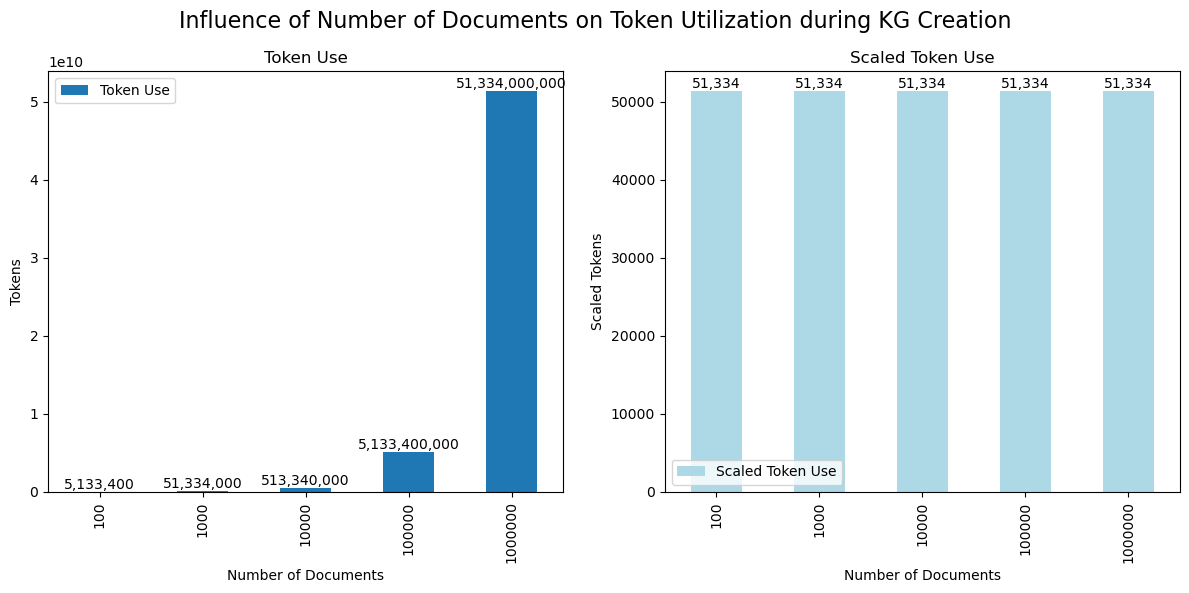

In [ ]:
N_DOCS_ = [100, 1_000, 10_000, 100_000, 1_000_000]

token_use = [
    {
        "n_documents": n,
        "tokens": kg_token_use(
            n_docs=n,
            doc_tokens=DOC_TOKENS,
            kg_chunk_tokens=KG_CHUNK_TOKENS,
        ),
    }
    for n in N_DOCS_
]

df = pd.DataFrame.from_records(token_use)
plot_token_use(
    df,
    title="Influence of Number of Documents on Token Utilization during KG Creation",
    x_col="n_documents",
    x_label="Number of Documents",
)

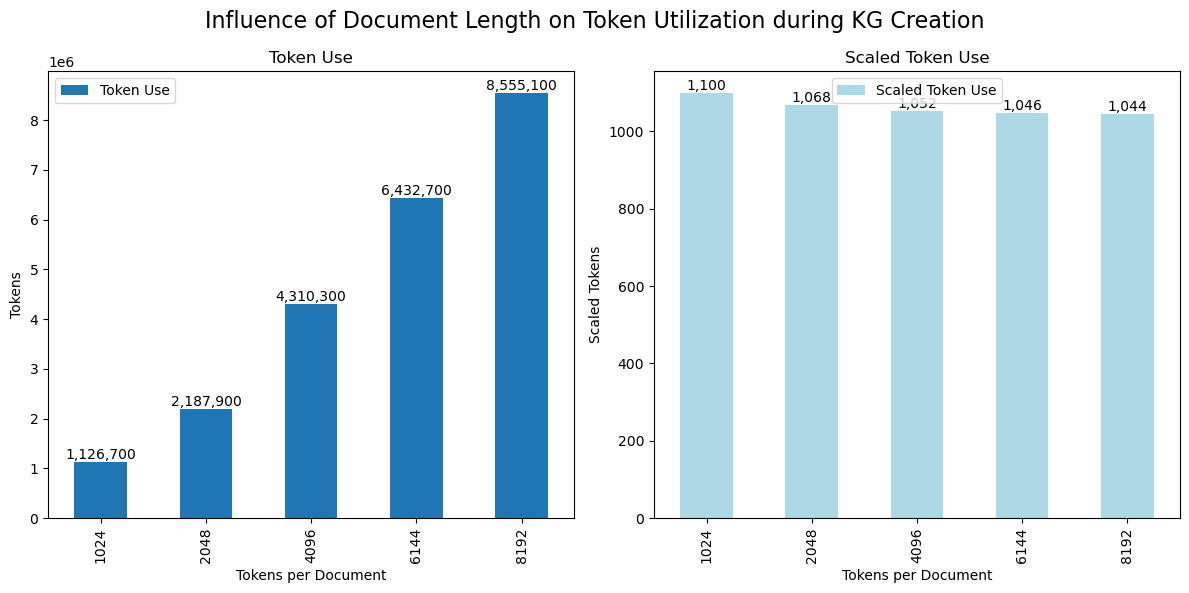

In [ ]:
DOC_TOKENS_ = [1024, 2048, 4096, 6144, 8192]
token_use = [
    {
        "tokens_per_doc": n,
        "tokens": kg_token_use(
            n_docs=N_DOCS,
            doc_tokens=n,
            kg_chunk_tokens=KG_CHUNK_TOKENS,
        ),
    }
    for n in DOC_TOKENS_
]

df = pd.DataFrame.from_records(token_use)
plot_token_use(
    df,
    title="Influence of Document Length on Token Utilization during KG Creation",
    x_col="tokens_per_doc",
    x_label="Tokens per Document",
)

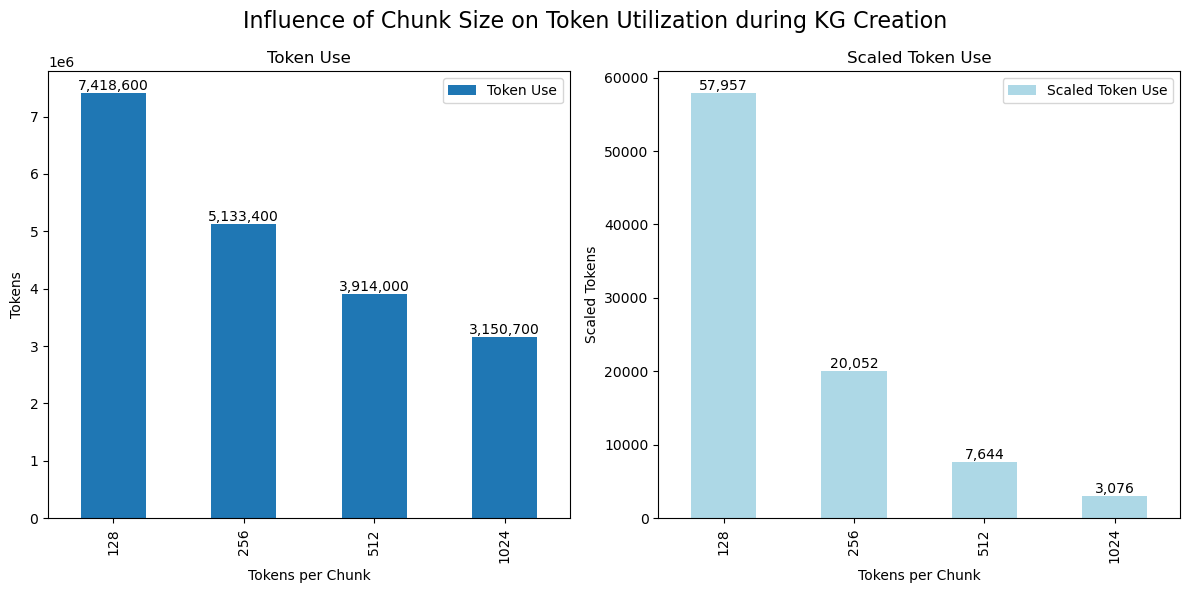

In [ ]:
CHUNK_TOKENS_ = [128, 256, 512, 1024]  # use chunk_tokens instead of doc_chunks b/c used in downstream calcs
token_use = [
    {
        "tokens_per_chunk": n,
        "tokens": kg_token_use(
            n_docs=N_DOCS,
            doc_tokens=DOC_TOKENS,
            kg_chunk_tokens=n,
        ),
    }
    for n in CHUNK_TOKENS_
]

df = pd.DataFrame.from_records(token_use)
plot_token_use(
    df,
    title="Influence of Chunk Size on Token Utilization during KG Creation",
    x_col="tokens_per_chunk",
    x_label="Tokens per Chunk",
)

### Testset Generation

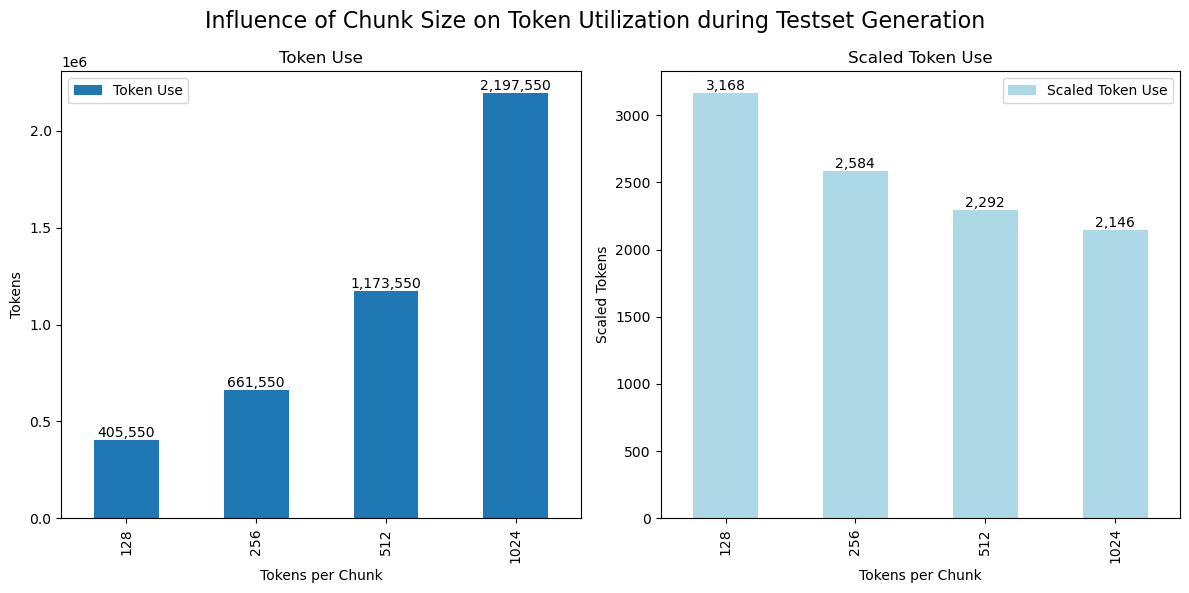

In [ ]:
CHUNK_TOKENS_ = [128, 256, 512, 1024]  # use chunk_tokens instead of doc_chunks b/c used in downstream calcs
token_use = [
    {
        "tokens_per_chunk": n,
        "tokens": testset_token_use(
            kg_chunk_tokens=n,
            n_nodes=N_NODES,
            testset_size=TESTSET_SIZE,
        ),
    }
    for n in CHUNK_TOKENS_
]

df = pd.DataFrame.from_records(token_use)
plot_token_use(
    df,
    title="Influence of Chunk Size on Token Utilization during Testset Generation",
    x_col="tokens_per_chunk",
    x_label="Tokens per Chunk",
)

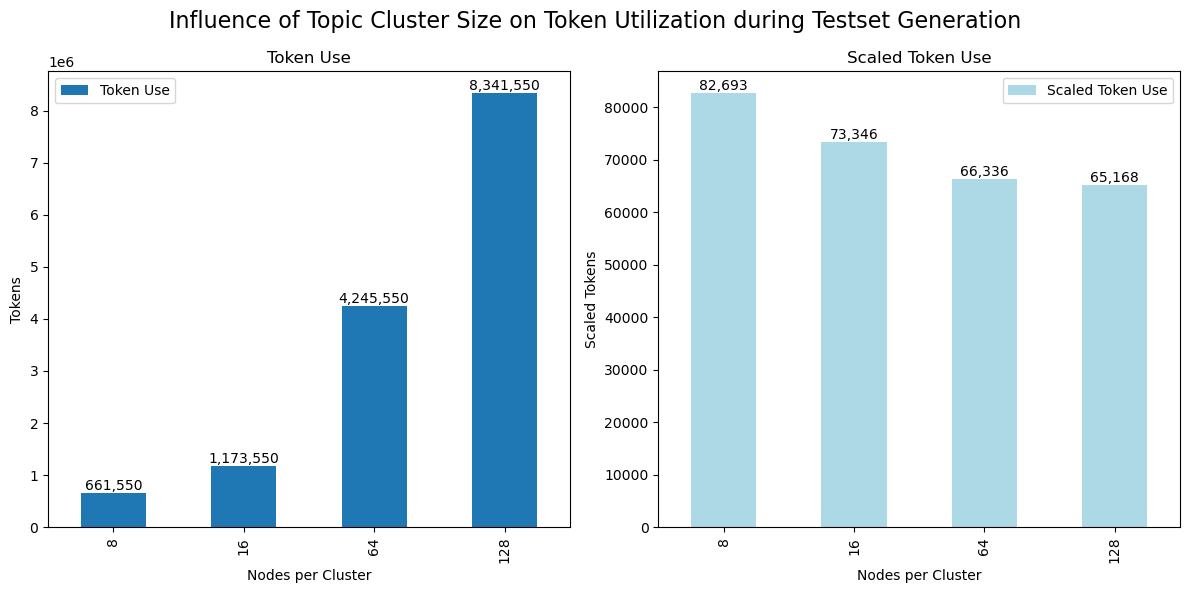

In [ ]:
N_NODES_ = [8, 16, 64, 128]
# assumed number of nodes per cluster used as reference context for reference response generation
token_use = [
    {
        "nodes_per_cluster": n,
        "tokens": testset_token_use(
            kg_chunk_tokens=KG_CHUNK_TOKENS,
            n_nodes=n,
            testset_size=TESTSET_SIZE,
        ),
    }
    for n in N_NODES_
]

df = pd.DataFrame.from_records(token_use)
plot_token_use(
    df,
    title="Influence of Topic Cluster Size on Token Utilization during Testset Generation",
    x_col="nodes_per_cluster",
    x_label="Nodes per Cluster",
)

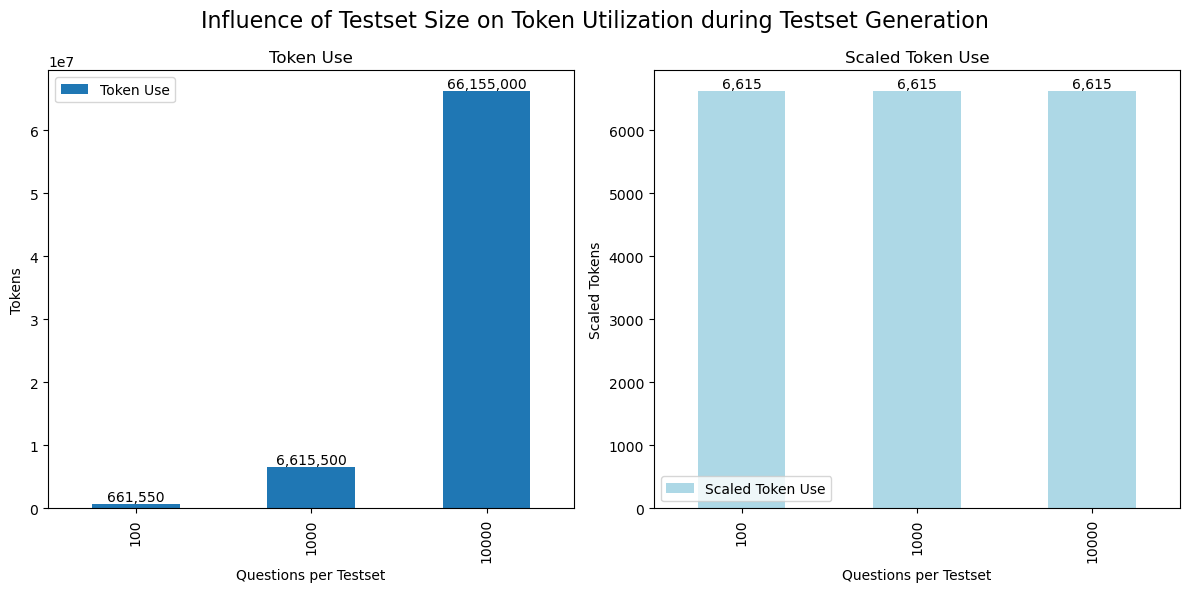

In [ ]:
TESTSET_SIZE_ = [100, 1_000, 10_000]
token_use = [
    {
        "tokens_per_testset": n,
        "tokens": testset_token_use(
            kg_chunk_tokens=KG_CHUNK_TOKENS,
            n_nodes=N_NODES,
            testset_size=n,
        ),
    }
    for n in TESTSET_SIZE_
]

df = pd.DataFrame.from_records(token_use)
plot_token_use(
    df,
    title="Influence of Testset Size on Token Utilization during Testset Generation",
    x_col="tokens_per_testset",
    x_label="Questions per Testset",
)

### Evaluation

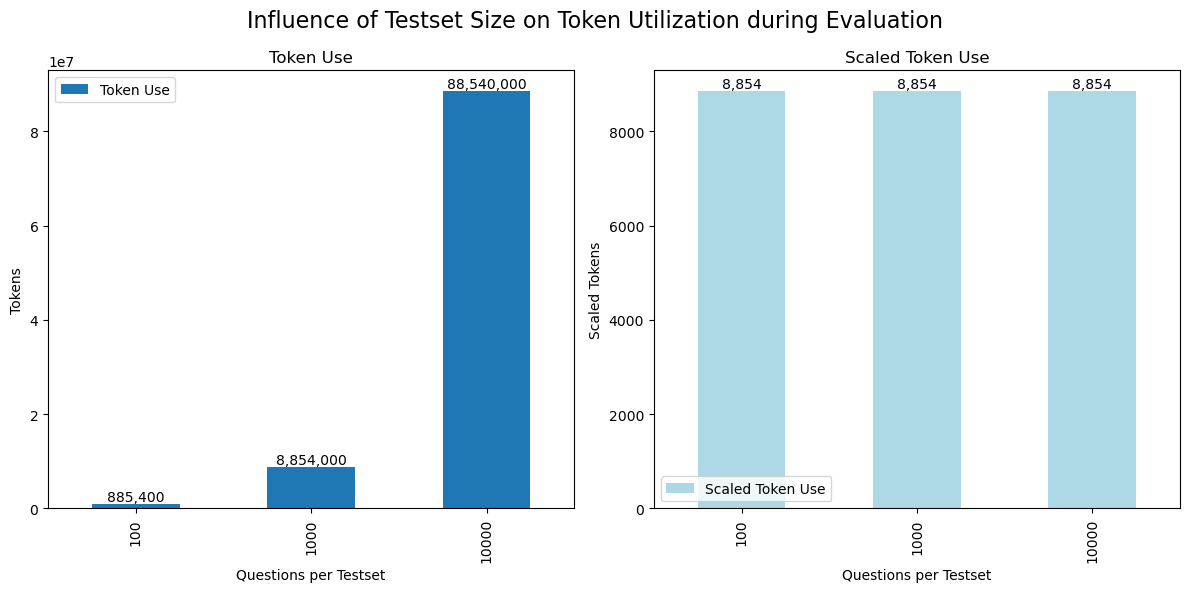

In [ ]:
TESTSET_SIZE_ = [100, 1_000, 10_000]
token_use = [
    {
        "tokens_per_testset": n,
        "tokens": eval_token_use(
            testset_size=n,
            user_input_tokens=ASSUMED_USER_INPUT_TOKENS,
            reference_tokens=ASSUMED_REFERENCE_TOKENS,
            rag_chunk_tokens=RAG_CHUNK_TOKENS,
            rag_chunks=RAG_CHUNKS,
            response_tokens=ASSUMED_RESPONSE_TOKENS,
        ),
    }
    for n in TESTSET_SIZE_
]

df = pd.DataFrame.from_records(token_use)
plot_token_use(
    df,
    title="Influence of Testset Size on Token Utilization during Evaluation",
    x_col="tokens_per_testset",
    x_label="Questions per Testset",
)

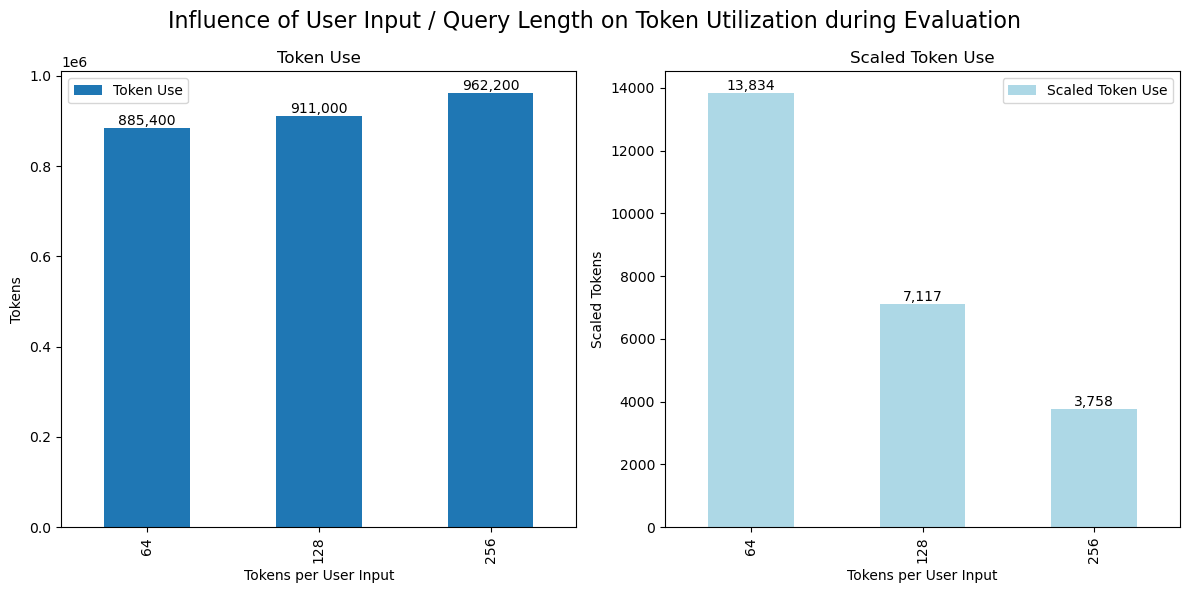

In [ ]:
ASSUMED_USER_INPUT_TOKENS_ = [64, 128, 256]
token_use = [
    {
        "tokens_per_input": n,
        "tokens": eval_token_use(
            testset_size=TESTSET_SIZE,
            user_input_tokens=n,
            reference_tokens=ASSUMED_REFERENCE_TOKENS,
            rag_chunk_tokens=RAG_CHUNK_TOKENS,
            rag_chunks=RAG_CHUNKS,
            response_tokens=ASSUMED_RESPONSE_TOKENS,
        ),
    }
    for n in ASSUMED_USER_INPUT_TOKENS_
]

df = pd.DataFrame.from_records(token_use)
plot_token_use(
    df,
    title="Influence of User Input / Query Length on Token Utilization during Evaluation",
    x_col="tokens_per_input",
    x_label="Tokens per User Input",
)

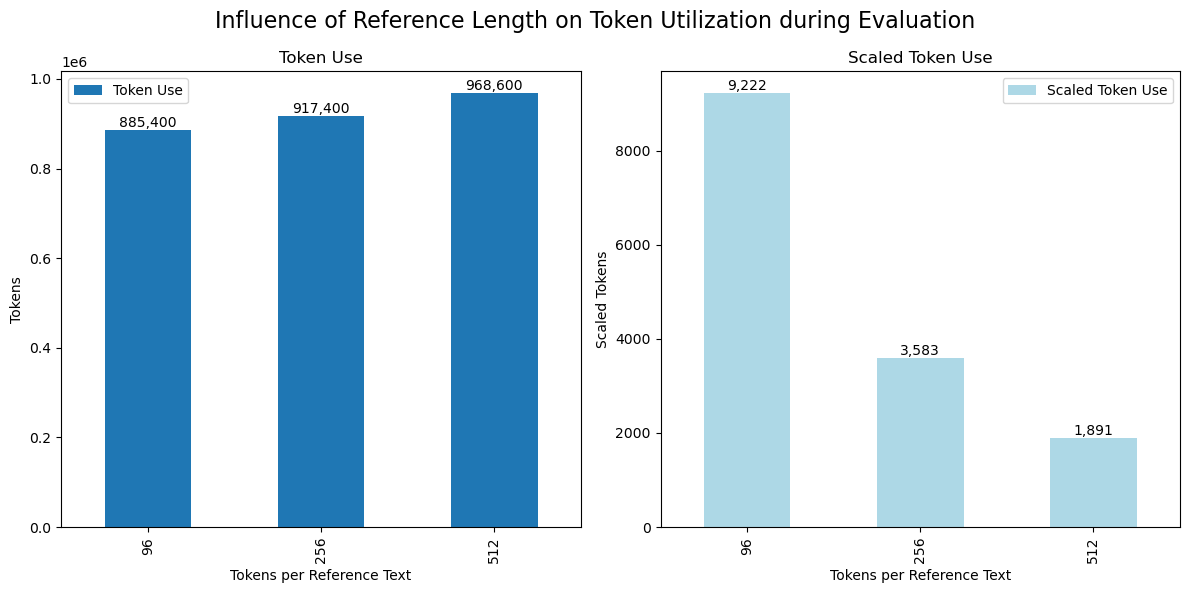

In [ ]:
ASSUMED_REFERENCE_TOKENS_ = [96, 256, 512]
token_use = [
    {
        "tokens_per_reference": n,
        "tokens": eval_token_use(
            testset_size=TESTSET_SIZE,
            user_input_tokens=ASSUMED_USER_INPUT_TOKENS,
            reference_tokens=n,
            rag_chunk_tokens=RAG_CHUNK_TOKENS,
            rag_chunks=RAG_CHUNKS,
            response_tokens=ASSUMED_RESPONSE_TOKENS,
        ),
    }
    for n in ASSUMED_REFERENCE_TOKENS_
]

df = pd.DataFrame.from_records(token_use)
plot_token_use(
    df,
    title="Influence of Reference Length on Token Utilization during Evaluation",
    x_col="tokens_per_reference",
    x_label="Tokens per Reference Text",
)

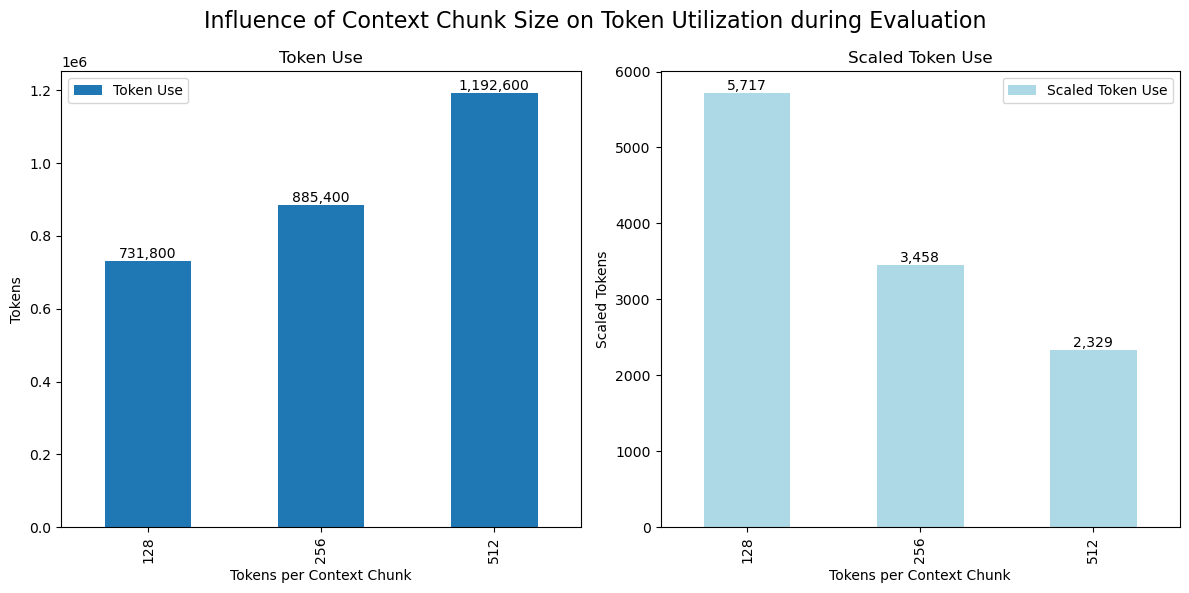

In [ ]:
CHUNK_TOKENS_ = [128, 256, 512]  # set in RAG
token_use = [
    {
        "tokens_per_chunk": n,
        "tokens": eval_token_use(
            testset_size=TESTSET_SIZE,
            user_input_tokens=ASSUMED_USER_INPUT_TOKENS,
            reference_tokens=ASSUMED_REFERENCE_TOKENS,
            rag_chunk_tokens=n,
            rag_chunks=RAG_CHUNKS,
            response_tokens=ASSUMED_RESPONSE_TOKENS,
        ),
    }
    for n in CHUNK_TOKENS_
]

df = pd.DataFrame.from_records(token_use)
plot_token_use(
    df,
    title="Influence of Context Chunk Size on Token Utilization during Evaluation",
    x_col="tokens_per_chunk",
    x_label="Tokens per Context Chunk",
)

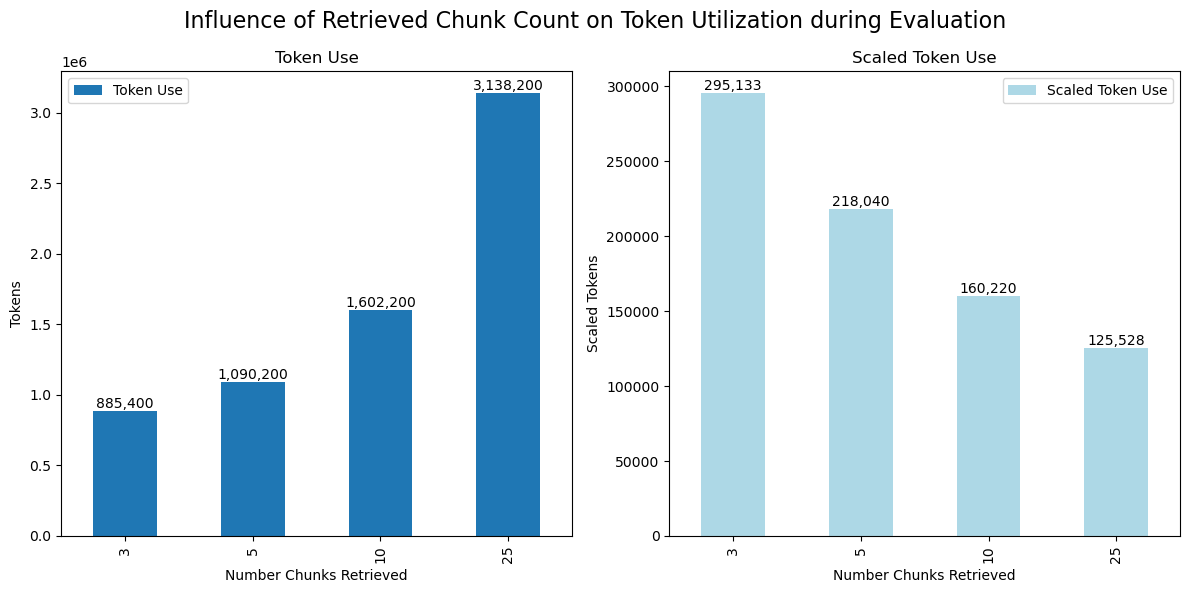

In [ ]:
N_CHUNKS_ = [3, 5, 10, 25]  # set in RAG
token_use = [
    {
        "n_chunks": n,
        "tokens": eval_token_use(
            testset_size=TESTSET_SIZE,
            user_input_tokens=ASSUMED_USER_INPUT_TOKENS,
            reference_tokens=ASSUMED_REFERENCE_TOKENS,
            rag_chunk_tokens=RAG_CHUNK_TOKENS,
            rag_chunks=n,
            response_tokens=ASSUMED_RESPONSE_TOKENS,
        ),
    }
    for n in N_CHUNKS_
]

df = pd.DataFrame.from_records(token_use)
plot_token_use(
    df,
    title="Influence of Retrieved Chunk Count on Token Utilization during Evaluation",
    x_col="n_chunks",
    x_label="Number Chunks Retrieved",
)

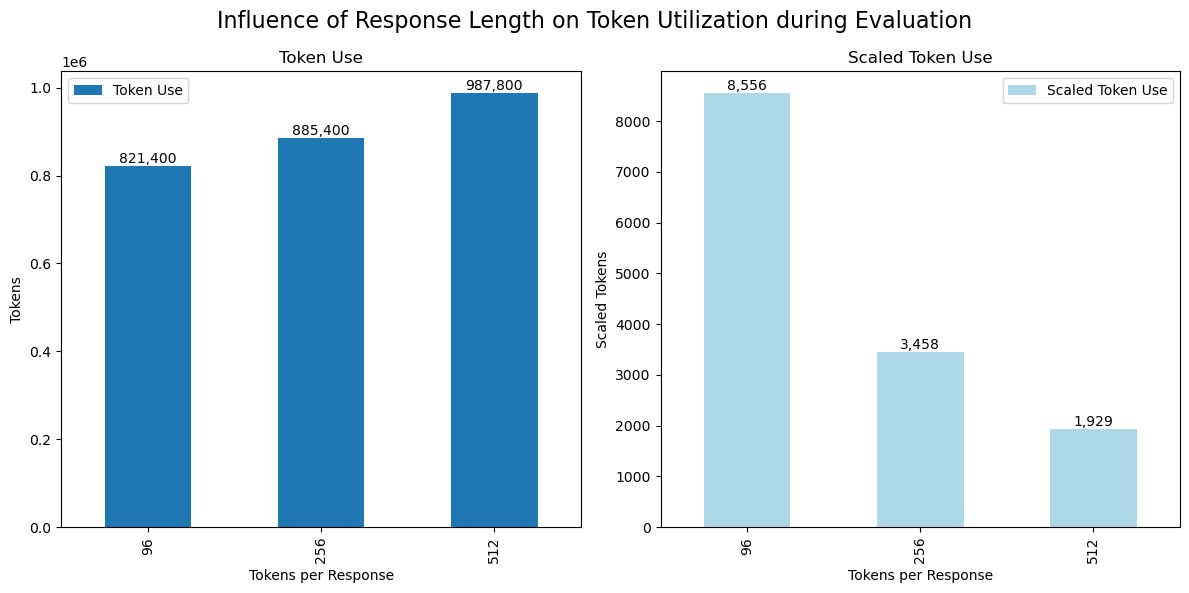

In [ ]:
ASSUMED_RESPONSE_TOKENS_ = [96, 256, 512]
token_use = [
    {
        "tokens_per_response": n,
        "tokens": eval_token_use(
            testset_size=TESTSET_SIZE,
            user_input_tokens=ASSUMED_USER_INPUT_TOKENS,
            reference_tokens=ASSUMED_REFERENCE_TOKENS,
            rag_chunk_tokens=RAG_CHUNK_TOKENS,
            rag_chunks=RAG_CHUNKS,
            response_tokens=n,
        ),
    }
    for n in ASSUMED_RESPONSE_TOKENS_
]

df = pd.DataFrame.from_records(token_use)
plot_token_use(
    df,
    title="Influence of Response Length on Token Utilization during Evaluation",
    x_col="tokens_per_response",
    x_label="Tokens per Response",
)